In [1]:
import polars as pl
import helper
import altair as alt
# import json
# from pathlib import Path
# import matplotlib.pyplot as plt
# from matplotlib.ticker import MultipleLocator
# import numpy as np
# import os
# %matplotlib ipympl 

### Plot the data

In [2]:
chart_source = pl.read_parquet('./data/chart-source-hurricanes.parquet')

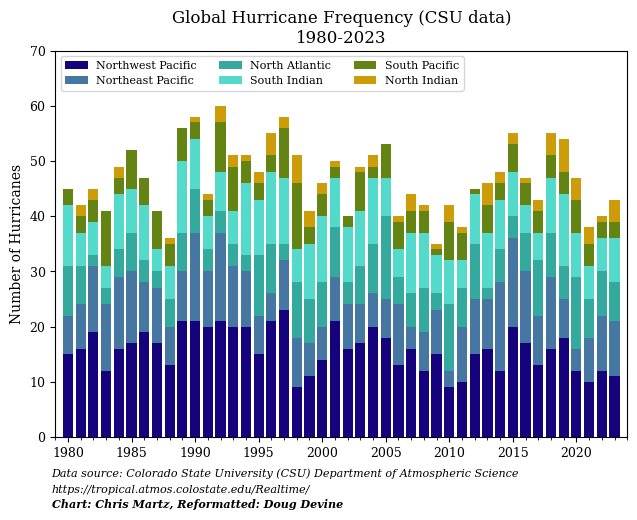

In [3]:
helper.make_chart(chart_source, 'hurricanes')

### Write combined data file if needed

In [4]:
helper.extract_chart_data(helper.combine_input_sources(), 'hurricanes')

No action necessary.


basin,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""northeastpacific""",7,8,12,12,13,13,9,10,7,9,16,10,16,11,10,7,5,9,9,6,6,8,8,7,6,7,11,4,7,8,3,10,10,9,16,16,13,9,13,7,4,8,10,10
"""southindian""",11,6,6,4,10,8,10,4,6,13,9,6,7,6,13,10,13,12,6,10,12,9,10,10,12,7,5,11,10,7,8,5,9,10,9,8,5,5,10,13,8,6,6,8
"""northatlantic""",9,7,2,3,5,7,4,3,5,7,8,4,4,4,3,11,9,3,10,8,8,9,4,7,9,15,5,6,8,3,12,7,10,2,6,4,7,10,8,6,13,7,8,7
"""southpacific""",3,3,4,10,3,7,5,7,4,6,3,3,9,8,4,3,3,9,12,3,4,2,2,7,2,6,5,4,4,1,7,5,1,5,3,5,4,4,4,4,6,4,3,3
"""northindian""",0,2,2,0,2,0,0,0,1,0,1,1,3,2,1,2,4,2,5,3,2,1,0,1,2,0,1,3,1,1,3,1,0,4,2,2,1,2,4,6,4,3,1,4
"""northwestpacific""",15,16,19,12,16,17,19,17,13,21,21,20,21,20,20,15,21,23,9,11,14,21,16,17,20,18,13,16,12,15,9,10,15,16,12,20,17,13,16,18,12,10,12,11


### Concerns

#### Concern: totals do not match
There are too many "close but not quite" values.

Could be due to source data files changing.  (Data from the web site is just a snapshot.)

#### Concern: consistent stack order
Chris' stack order is not consistent year after year.

When it exists, North Indian should be the top-most stack piece.

Yet 1990, 1992, 2006, 2013, and 2014 all show North Indian be the second top-most stack piece.


#### Concern: multiple stack pieces in the same year

eg, 1990 has two South Indian stack pieces.  So does 1992.

This raises concern about the aggregation of data.


### Did CSU's online data change?
Chris' chart is missing a bunch of (mainly) South Indian hurricanes.  One hypothesis is that the source data changed since he did his chart.

That hypothesis is dismissed when comparing the data found in the Internet Archive as we see below...

In [5]:
master_df = helper.combine_input_sources()

In [6]:
master_df

basin,season,named_storms,named_storm_days,hurricanes,hurricane_days,major_hurricanes,major_hurricane_days,ace
str,u16,i64,f64,i64,f64,i64,f64,f64
"""southindian-20240711""",1980,14,115.0,11,40.0,6,8.25,188.1
"""southindian-20240711""",1981,12,56.5,6,20.25,5,3.75,86.0
"""southindian-20240711""",1982,16,72.5,6,23.0,2,4.5,105.5
"""southindian-20240711""",1983,9,36.25,4,4.75,0,0.0,38.2
"""southindian-20240711""",1984,20,101.0,10,36.25,3,7.25,153.3
…,…,…,…,…,…,…,…,…
"""northwestpacific""",2019,30,129.25,18,55.75,11,23.75,276.8
"""northwestpacific""",2020,23,80.75,12,30.75,7,10.75,152.8
"""northwestpacific""",2021,23,105.25,10,38.0,5,18.5,209.6


In [7]:
oct = master_df.filter(pl.col('basin') == 'southindian').select(['basin', 'season', 'major_hurricanes'])
jul = master_df.filter(pl.col('basin') == 'southindian-20240711').select(['basin', 'season', 'major_hurricanes']).with_columns(pl.lit('southindian').alias('basin'))
dec = master_df.filter(pl.col('basin') == 'southindian-20231210').select(['basin', 'season', 'major_hurricanes']).with_columns(pl.lit('southindian').alias('basin'))

In [8]:
diffs = (
    oct
    .join(dec, on=['basin', 'season'], how='left')
    .fill_null(0)
    .with_columns(
        (pl.col('major_hurricanes') - pl.col('major_hurricanes_right')).alias('diff')
    )
)

In [9]:
diffs

basin,season,major_hurricanes,major_hurricanes_right,diff
str,u16,i64,i64,i64
"""southindian""",1980,6,6,0
"""southindian""",1981,5,5,0
"""southindian""",1982,2,2,0
"""southindian""",1983,0,0,0
"""southindian""",1984,3,3,0
…,…,…,…,…
"""southindian""",2020,5,5,0
"""southindian""",2021,3,3,0
"""southindian""",2022,5,0,5


In [10]:
diffs.max()

basin,season,major_hurricanes,major_hurricanes_right,diff
str,u16,i64,i64,i64
"""southindian""",2024,11,11,5


In [11]:
def make_diff_wayback_heatmap():
    diffs_scale = alt.Scale(
        domain=[-10, 0, 10],
        range=['red', 'transparent', 'green'],
    )

    heatmap = alt.Chart(diffs).encode(
        x='season:O',
        y='basin:N',
        color=alt.Color('diff:Q', scale=diffs_scale),
        tooltip=['season', 'basin', 'diff'],
    ).mark_rect()

    text = heatmap.mark_text().encode(
        text=alt.condition(
            alt.datum.value != 0,
            'diff:Q',
            alt.value('x') 
        )
    )

    chart = alt.layer(heatmap, text).properties(
        title='Differences in South Indian source data (October - previous)'
    )

    return chart

make_diff_wayback_heatmap()

alt.LayerChart(...)

Strange that the 3 most recent years don't appear in the .json file from Internet Archive but the table data is populated in the html for those years.